# Analysis of Public Comments Regarding the EPA's Revised Definition of "Waters of the United States" (WOTUS)

In early 2017, President Trump signed an Executive Order<sup>[1](#footnote1)</sup> requesting that agencies review a 2015 rule regarding the "Waters of the United States". The agencies, including the Environmental Protection Agency (EPA) and the Department of the Army, were instructed to rescind or replace the rule, in accordance with law.

The agencies have since conducted a reevaluation and revision of the definition of "Waters of the United States". Their proposed rule redefines the scope of waters federally regulated under the Clean Water Act (CWA). This rule was open for public comment until April 15, 2019.

This project aims to apply Natural Language Processing (NLP) techniques to analyze the content of comments that are publicly available on the [regulations.gov web page](https://www.regulations.gov/docket?D=EPA-HQ-OW-2018-0149) for this docket. For technical reasons (see the [Data_Prep notebook](./Data_Prep.ipynb)), the dataset only includes ~8K comments, which are the ones typed directly onto the site. The dataset excludes another ~3K comments submitted in an attachment form (most of which were PDFs).

Notes:

<a name="footnote1">1</a>: Executive Order 13778, signed on February 28, 2017, titled "Restoring the Rule of Law, Federalism, and Economic Growth by Reviewing the 'Waters of the United States' Rule"

## Library Imports

In [1]:
# Standard imports
import re
import warnings
warnings.filterwarnings('ignore', 'DeprecationWarning') 

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# Model and analysis imports
from scipy import linalg

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import LatentDirichletAllocation as LDA, NMF, PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn import metrics
from sklearn.manifold import TSNE

from wordcloud import WordCloud

In [3]:
full_df = pd.read_pickle('./Data/full_df.pkl')

full_df.head()

,Document Title,Document ID,Posted Date,Received Date,Document SubType,Post Mark Date,Document Detail,Comment
0,Anonymous public comment,EPA-HQ-OW-2018-0149-6689,2019-04-29,2019-04-11,Public Comment,04/11/2019,https://www.regulations.gov/document?D=EPA-HQ-...,I write to express my opposition to the Enviro...
1,Anonymous public comment,EPA-HQ-OW-2018-0149-6688,2019-04-29,2019-04-11,Public Comment,04/11/2019,https://www.regulations.gov/document?D=EPA-HQ-...,I write to express my opposition to the Enviro...
2,Anonymous public comment,EPA-HQ-OW-2018-0149-7377,2019-05-01,2019-04-11,Public Comment,04/11/2019,https://www.regulations.gov/document?D=EPA-HQ-...,Please abandon this proposed rollback of the 2...
3,Anonymous public comment,EPA-HQ-OW-2018-0149-6707,2019-04-29,2019-04-11,Public Comment,04/11/2019,https://www.regulations.gov/document?D=EPA-HQ-...,"My husband and I have two wonderful daughters,..."
4,Comment submitted by T. Dahlin,EPA-HQ-OW-2018-0149-7983,2019-05-01,2019-04-12,Public Comment,04/12/2019,https://www.regulations.gov/document?D=EPA-HQ-...,Please do not change the definitions within th...


## Topic Analysis

In [4]:
# Process comment column for topic analysis

# Remove punctuation
full_df['Comment_processed'] = full_df['Comment'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the comments to lowercase
full_df['Comment_processed'] = full_df['Comment'].map(lambda x: x.lower())

full_df.head()

,Document Title,Document ID,Posted Date,Received Date,Document SubType,Post Mark Date,Document Detail,Comment,Comment_processed
0,Anonymous public comment,EPA-HQ-OW-2018-0149-6689,2019-04-29,2019-04-11,Public Comment,04/11/2019,https://www.regulations.gov/document?D=EPA-HQ-...,I write to express my opposition to the Enviro...,i write to express my opposition to the enviro...
1,Anonymous public comment,EPA-HQ-OW-2018-0149-6688,2019-04-29,2019-04-11,Public Comment,04/11/2019,https://www.regulations.gov/document?D=EPA-HQ-...,I write to express my opposition to the Enviro...,i write to express my opposition to the enviro...
2,Anonymous public comment,EPA-HQ-OW-2018-0149-7377,2019-05-01,2019-04-11,Public Comment,04/11/2019,https://www.regulations.gov/document?D=EPA-HQ-...,Please abandon this proposed rollback of the 2...,please abandon this proposed rollback of the 2...
3,Anonymous public comment,EPA-HQ-OW-2018-0149-6707,2019-04-29,2019-04-11,Public Comment,04/11/2019,https://www.regulations.gov/document?D=EPA-HQ-...,"My husband and I have two wonderful daughters,...","my husband and i have two wonderful daughters,..."
4,Comment submitted by T. Dahlin,EPA-HQ-OW-2018-0149-7983,2019-05-01,2019-04-12,Public Comment,04/12/2019,https://www.regulations.gov/document?D=EPA-HQ-...,Please do not change the definitions within th...,please do not change the definitions within th...


In [5]:
comments = full_df['Comment_processed']

comments.head()

0    i write to express my opposition to the enviro...
1    i write to express my opposition to the enviro...
2    please abandon this proposed rollback of the 2...
3    my husband and i have two wonderful daughters,...
4    please do not change the definitions within th...
Name: Comment_processed, dtype: object

In [6]:
# Helper function to show top words per topics
def show_topics(Vh, vocab_array, n_top_words=8):
    """
    Returns a list of the n_top_words from topic matrix Vh
    :param Vh: a topic-by-vocabulary orthonormal matrix
    :param vocab_array: a Numpy array of the vocabulary terms
        from the documents used in the analysis
    :param n_top_words: int of how many words to show by topic
    :return: list of strings with top words by topic in Vh
    
    >>>show_topics(my_Vh_matrix[:4], vocab)
    ['space launch satellite nasa commercial market satellites data',
     'god atheists atheism religious believe argument religion true',
     'nasa space lunar available mars probe moon edu',
     'atheists religious atheism god religion believe belief atheist']
    """
    top_words = lambda t: [vocab_array[i] for i in np.argsort(t)[:-n_top_words-1:-1]]
    topic_words = ([top_words(t) for t in Vh])
    return [' '.join(t) for t in topic_words]

In [7]:
# Helper function to plot most common words
def plot_most_common_words(count_data, count_vect, n=10):
    """
    :param count_data: data after running a CountVectorizer.fit_transform()
    :param count_vect: a CountVectorizer() instance
    :param n: int for how many top words to plot
    :return: None; plots a matplotlib.pyplot bar chart of top n words
    """
    import matplotlib.pyplot as plt
    
    words = count_vect.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts += t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:n]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 

    plt.bar(x_pos, counts,align='center')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('Words')
    plt.ylabel('Counts')
    plt.title('{} Most Common Words'.format(n))
    plt.show()

In [8]:
# Transform comments to a matrix of comments by word counts
#   then to normalized TF-IDF representation

# Create frequency counts and generate corpus vocabulary
count_vec = CountVectorizer(stop_words='english')
count_data = count_vec.fit_transform(comments)
print(count_data.shape)

# Create array of vocabulary terms
vocab = np.array(count_vec.get_feature_names())

# Calculate TF-IDF stats
tfidf = TfidfTransformer()
tfidf_data = tfidf.fit_transform(count_data)
print(tfidf_data.shape)

(8187, 22434)
(8187, 22434)


In [9]:
# Test just TFIDF vectorizer
tf_vec = TfidfVectorizer(stop_words='english')
tfv_data = tf_vec.fit_transform(comments)
vocab_2 = np.array(tf_vec.get_feature_names())
print(tfv_data.shape)

(8187, 22434)


In [10]:
s = 1100
print(vocab[s:s+100])

['abomination' 'abound' 'abounds' 'aboutepa' 'aboveground' 'aboveis' 'abq'
 'abraham' 'abrahams' 'abrahamson' 'abrams' 'abreast' 'abridge' 'abridged'
 'abroad' 'abrogated' 'abrogation' 'abrsorbing' 'abruptly' 'absence'
 'absent' 'absolute' 'absolutely' 'absolve' 'absorb' 'absorbed'
 'absorbing' 'absorbs' 'absorption' 'abstention' 'abstract' 'absurd'
 'absurdities' 'absurdity' 'absurdly' 'abudent' 'abudt' 'abundance'
 'abundant' 'abundent' 'abuse' 'abused' 'abuses' 'abusing' 'abusive'
 'abut' 'abuting' 'abuts' 'abutted' 'abutting' 'abysmal' 'academia'
 'academic' 'academically' 'academy' 'accelerate' 'accelerated'
 'accelerates' 'accelerating' 'accept' 'acceptability' 'acceptable'
 'acceptance' 'accepted' 'acceptible' 'accepting' 'accepts' 'access'
 'accesse' 'accessed' 'accessibility' 'accessible' 'accessing'
 'accheivment' 'accident' 'accidental' 'accidentally' 'accidents'
 'accolades' 'accomadate' 'accommodate' 'accommodating' 'accomodate'
 'accompanied' 'accompanies' 'accompany' 'ac

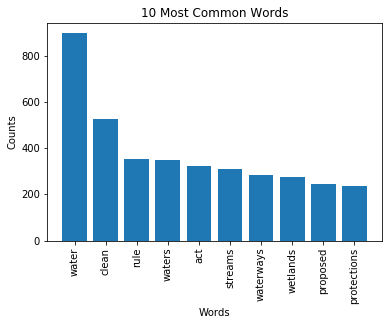

In [11]:
plot_most_common_words(tfidf_data, count_vec)

### Word Cloud

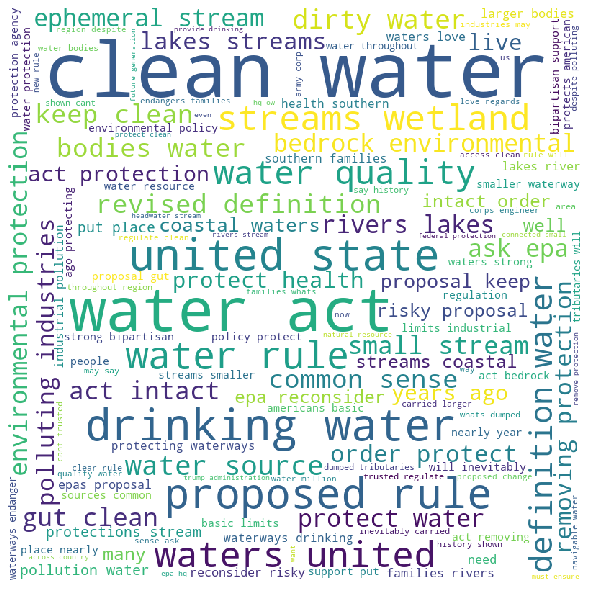

In [12]:
# Combine comments into one "text"
text = ' '.join(comments)

wordcloud = WordCloud(width = 800,
                      height = 800, 
                      background_color ='white',
                      min_font_size = 10).generate(text)

# Plot the word cloud
plt.figure(figsize = (8, 8), facecolor=None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad=0)  
plt.show() 

### Singular Value Decomposition (SVD) Analysis

In [168]:
# Run SVD to create topic matrices
U, s, Vh = linalg.svd(tfv_data.todense(), full_matrices=False)
print(U.shape, s.shape, Vh.shape)

(8187, 8187) (8187,) (8187, 22434)


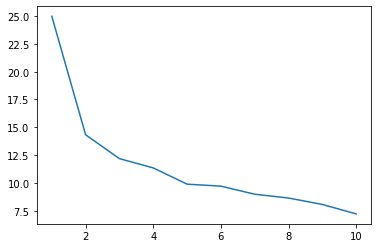

In [169]:
# Plot s to see where topic importance drops off
plt.plot(range(1, 11), s[:10]);

In [170]:
# Print top 10 topics
show_topics(Vh[:10], vocab)

['torrance rosamond winthrop devan faillacetarrytown jaegerssaint gratefully ironic',
 'families proposal risky bipartisan love limits coastal waterways',
 'communities dirty polluters instead safeguards jeopardy corporate abandon',
 'rules farmers clear land support need farm follow',
 'waters united states dangerous definition dirty revised agencys',
 'united dangerous states dirty waters concerned harmed protections',
 'park parks small clean country downstream control roll',
 'park parks water quality vital roll country adapt',
 'waterways wotus definition percent waters changes states categories',
 'waterways categories percent rules recreate unprotected nevada arizona']

Aside from the gibberish that comprises the first topic, the others all seem to reasonably fit the core themes in the public comments.

### LDA

LDA analysis had much higher perplexity scores (12K vs 995 at 12 topics) using the TF-IDF count data vs. the standard count vectorizer.

In [13]:
n_topics = 12

# Create and fit an LDA model
lda = LDA(n_components=n_topics,
          n_jobs=-1,
          random_state=42)

lda.fit(count_data)  # tfidf_data had much higher perplexity scores

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=12, n_jobs=-1,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [14]:
lda.components_.shape

(12, 22434)

In [15]:
print('Final perplexity score: {0:,.0f}'.format(lda.bound_))

Final perplexity score: 995


In [16]:
show_topics(lda.components_, vocab)

['water rules clean rule farmers land clear support',
 'water clean act waterways streams proposal waters drinking',
 'waters definition wotus regulation property water states regards',
 'water rivers new streams industry creeks life pollute',
 'water wetlands waters rule proposed streams clean protection',
 'water waters states united definition act clean regulations',
 'water clean people life protect environment need future',
 'water clean waters protections wetlands streams act rule',
 'rule proposed water waters definition epa wotus support',
 'water streams wetlands clean rule downstream proposed waterways',
 'water clean rule communities waterways epa wetlands polluters',
 'regards comment write irrigation wheeler mr people idaho']

In [17]:
# Compare perplexity scores for various number of topics
p = []

for n in range(2, 19, 2):
    mod = LDA(n_components=n,
              n_jobs=-1,
              random_state=42)
    mod.fit(count_data)
    p.append(mod.bound_)
    print('Number of Topics: {}'.format(n))
    print('Perplexity score: {0:,.0f}'.format(mod.bound_))
    print('----------------')

Number of Topics: 2
Perplexity score: 1,236
----------------
Number of Topics: 4
Perplexity score: 1,147
----------------
Number of Topics: 6
Perplexity score: 1,110
----------------
Number of Topics: 8
Perplexity score: 1,071
----------------
Number of Topics: 10
Perplexity score: 1,022
----------------
Number of Topics: 12
Perplexity score: 995
----------------
Number of Topics: 14
Perplexity score: 979
----------------
Number of Topics: 16
Perplexity score: 976
----------------
Number of Topics: 18
Perplexity score: 965
----------------


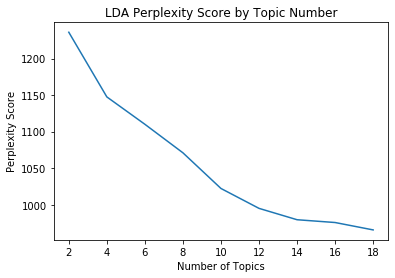

In [18]:
# Plot the perplexity scores
plt.plot(range(2, 19, 2), p);
plt.title('LDA Perplexity Score by Topic Number');
plt.ylabel('Perplexity Score');
plt.xlabel('Number of Topics');

The sharpest decline in perplexity score happens from two to four topics, with steady declines until 10-12 topics. After that point, the scores still drop but at a much slower rate.

### NMF

In [19]:
# Create and fit an NMF model with just CountVectorizer
nmf = NMF(n_components=n_topics,
          random_state=42)

W1 = nmf.fit_transform(count_data)
H1 = nmf.components_

In [20]:
show_topics(H1, vocab)

['water clean act protections protect drinking river life',
 'waters states united definition federal act navigable ephemeral',
 'streams wetlands downstream rule proposed flow small rivers',
 'waterways water act proposal streams families waters drinking',
 'rule proposed epa wotus case 2015 support environmental',
 'water farmers rules land rule epa clear new',
 'waterways rule proposed streams wetlands new categories protections',
 'water protections park streams quality wetlands clean parks',
 'waters united states dirty rule dangerous people water',
 'water clean communities rule epa polluters waterways dirty',
 'water definition wotus proposed drinking cwa bodies rule',
 'wetlands streams protection wetland epa wildlife species ecosystems']

In [23]:
# Create and fit an NMF model with TF-IDF Vectorizer
nmf_tf = NMF(n_components=n_topics,
          random_state=42)

W1_tf = nmf_tf.fit_transform(tfv_data)
H1_tf = nmf_tf.components_

In [24]:
show_topics(H1_tf, vocab)

['definition wotus waters rule states united 2015 proposed',
 'water waterways families act proposal clean streams love',
 'water communities clean dirty polluters instead rule families',
 'rules farmers land clear water support new landowners',
 'concerned harmed protections overall remove loss rappahannock impact',
 'dangerous dirty united waters states agencys water jeopardize',
 'blanket handout arroyos acequias disregards connectivity cinegas imperative',
 'park parks water protections wetlands quality streams small',
 'downstream streams wetlands flow small rule allowing water',
 'waterways categories proposed unprotected recreate mexico arizona nevada',
 'water clean life act protect need people regulations',
 'niagara usepa percent wetlands streams buffalo waters including']

In [21]:
# Create and fit an NMF model with CountVectorizer then TF-IDF Transformer
nmf_ctf = NMF(n_components=n_topics,
          random_state=42)

W1_ctf = nmf_ctf.fit_transform(tfidf_data)
H1_ctf = nmf_ctf.components_

In [22]:
show_topics(H1_ctf, vocab)

['definition wotus waters rule states united 2015 proposed',
 'water waterways families act proposal clean streams love',
 'water communities clean dirty polluters instead rule families',
 'rules farmers land clear water support new landowners',
 'concerned harmed protections overall remove loss rappahannock impact',
 'dangerous dirty united waters states agencys water jeopardize',
 'blanket handout arroyos acequias disregards connectivity cinegas imperative',
 'park parks water protections wetlands quality streams small',
 'downstream streams wetlands flow small rule allowing water',
 'waterways categories proposed unprotected recreate mexico arizona nevada',
 'water clean life act protect need people regulations',
 'niagara usepa percent wetlands streams buffalo waters including']

As expected, this outcome matches the TF-IDF vectorizer - sometimes it's nice to verify the claim that the same math is performed under the hood.

## Clustering Analysis

In [25]:
# Create dataset from original comments; form training/test sets
X = full_df['Comment']

X_train, X_test = train_test_split(X,
                                   test_size=.2,
                                   random_state=42)

print(X_train.shape, X_test.shape)

(6549,) (1638,)


In [30]:
# Create various options for the word vectorizer
n_feats = 5000
use_bigrams = False

if use_bigrams:
    b = 2
else:
    b = 1

# Comment out all vectorizer defs except the one to use
# Simple count vectorizer
# vectorizer = CountVectorizer(stop_words='english',
#                              ngram_range=(1, b),
#                              max_features=n_feats)

# Hashing vectorizer using L2 norm
vectorizer = HashingVectorizer(stop_words='english',
                               n_features=n_feats,
                               ngram_range=(1, b),
                               norm='l2')

# Hashing vectorizer normalized using TF-IDF
# hashy = HashingVectorizer(n_features=n_feats,
#                            stop_words='english',
#                            ngram_range=(1, b),
#                            norm=None)

# vectorizer = make_pipeline(hashy, TfidfTransformer())

# TF-IDF vectorizer
# vectorizer = TfidfVectorizer(max_features=n_feats,
#                              ngram_range=(1, b),
#                              stop_words='english')

In [31]:
# Transformed features
X_data = vectorizer.fit_transform(X_train)
print(X_data.shape)

(6549, 5000)


In [16]:
# Create and fit a KMeans algorithm
kmeans = KMeans(n_clusters=2,
                max_iter=100,
                n_init=1,
                n_jobs=-1)

kmeans.fit(X_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=2, n_init=1, n_jobs=-1, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [17]:
# Examine metrics for KMeans
# print(kmeans.labels_)
print('Inertia: {0: .3f}'.format(kmeans.inertia_))
print('Silhouette Coefficient: {0:.3f}'.format(
      metrics.silhouette_score(X_data, kmeans.labels_, sample_size=1000)))

Inertia:  4879.316
Silhouette Coefficient: 0.072


In [134]:
# Compare metrics of different number of clusters
n_clusters = list(range(2, 13))
inertias = []
silhouettes = []

for n in n_clusters:
    model = KMeans(n_clusters=n,
                   max_iter=100,
                   n_init=1,
                   n_jobs=-1)
    model.fit(X_data)
    inertias.append(model.inertia_)
    silhouettes.append(metrics.silhouette_score(X_data, model.labels_, sample_size=1000))

NameError: name 'n_clusters' is not defined

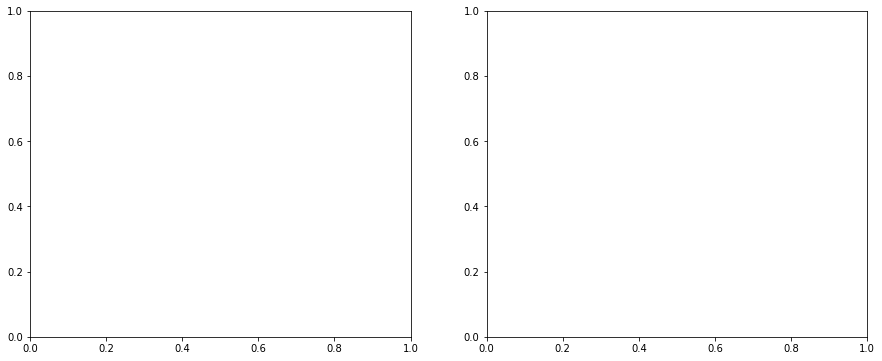

In [89]:
# Plot scores by cluster
plt.subplots(1, 2, figsize=(15, 6))

# Cluster-inertia plot
plt.subplot(1, 2, 1);
plt.plot(n_clusters, inertias, 'bo--');
plt.xlabel('Number of Clusters');
plt.ylabel('Inertia Score');
plt.title('KMeans: Inertia Score by Cluster Count\nFeatures: {}'.format(X_data.shape[1]));

# Cluster-silhouette score plot
plt.subplot(1, 2, 2);
plt.plot(n_clusters, silhouettes, 'ro--');
plt.xlabel('Number of Clusters');
plt.ylabel('Silhouette Score');
plt.title('KMeans: Silhouette Score by Cluster Count');

# plt.savefig('./Figures/KMeans_HashingL2_Inertia-Silhouette.png');
# plt.savefig('./Figures/KMeans_HashingL2_Bigrams_Inertia-Silhouette.png');
# plt.savefig('./Figures/KMeans_HashingL2_5000_Inertia-Silhouette.png');
# plt.savefig('./Figures/KMeans_HashingL2_5000_Bigrams_Inertia-Silhouette.png');
# plt.savefig('./Figures/KMeans_Count_5000_Inertia-Silhouette.png');
# plt.savefig('./Figures/KMeans_HashingTFIDF_Inertia-Silhouette.png');
# plt.savefig('./Figures/KMeans_TFIDF_Inertia-Silhouette.png');

**Inertia** calculates the sum of the squared distances between data points and their nearest cluster. Low overall values of inertia are generally better, but it will naturally favor having more clusters.

**Silhouette score** uses two scores to find the mean distance between each observation and all others - both in the same cluster and then in the nearest cluster. Values range from -1 to 1, where a score of 1 indicates the point is close to others in the same cluster, but far away from the next cluster over. A score near -1 indicates the point is not near ones in its cluster but close to the next nearest cluster. And a score of 0 indicates overlapping clusters, where an observation is close to the decision boundary. A score closest to 1 is ideal, as that indicates tight, highly separable clusters.

The KMeans algorithm was run with four different pre-processing applications, then using unigrams only vs. also including bigrams. Including bigrams did not generally improve the metrics, therefore the charts weren't included below.

1) **Hashing Vectorizer with L2 Norm**

![Inertia and silhouette scores by cluster](./Figures/KMeans_HashingL2_Inertia-Silhouette.png)

This method had the lowest overall inertia values and second highest overall silhouette scores.

While the inertia score is the highest for two clusters (as expected), the silhouette score favors two clusters as being the optimal number. This aligns with the nature of the dataset having sets of comments from two distinct groups: those that support the rule change and those that oppose it.

There are two trends worth pointing out in these chart. One is the jump from eight clusters to nine - there's little improvement to the inertia calculation, but almost a 4x improvement of silhouette score. This is repeated to a lesser degree in the move from ten to eleven clusters. The other is the move from four to five clusters - there's a steady decrease in inertia but an almost 2x increase in the silhouette score.

2) **Count Vectorizer**

![Count vectorizer plots](./Figures/KMeans_Count_5000_Inertia-Silhouette.png)

The count vectorizer plots had inertia values that were a factor of a hundred higher than all the others, but managed the highest overall silhouette scores, with the peak value over 0.3 at two clusters.

3) **Hashing Vectorizer Normalized using TF-IDF**

![Inertia and silhouette scores by cluster](./Figures/KMeans_HashingTFIDF_Inertia-Silhouette.png)

This analysis shows a completely different story, indicating that ten clusters is optimal. That cluster count has both the minimum inertia value as well as the peak silhouette score. However, the overall inertia and silhouette values are worse than the previous analysis using an L2 norm. The inertia scores are all higher, and the best silhouette score is still below the two-cluster score from before.

4) **TF-IDF Vectorizer**

![Inertia and silhouette scores by cluster](./Figures/KMeans_TFIDF_Inertia-Silhouette.png)

Not surprisingly, this analysis is more similar to the hashing vectorizer with TF-IDF normalization than the hashing vectorizer with an L2 norm. The overall score values are in line with where they fell out in the other TF-IDF-based analysis. Nine seems to be a good choice of clusters, with its dip in inertia and jump in silhouette scores (especially off the trough at eight clusters). However, the silhouette scores continue to climb at the limit of twelve clusters, indicating there could be better performance.

In [18]:
# Print comments from cluster 0
cluster_0 = X_train[kmeans.labels_ == 0]

for row in cluster_0.head(20):
    print(row)
    print('\n----------\n')

We da people have da power to send u to Washington with our votes,should be ashamed to take our property rights,may this world find da Lord's mercy especially TV those that abuse da system...!! Regards, William Perez

----------

April 15, 2019U.S. Environmental Protection Agency EPA Docket Center Office of Water DocketMail Code 28221T 1200 Pennsylvania Avenue, NWWashington, DC 20460RE:Docket ID No. EPA-HQ-OW-2018-0149To Whom it May Concern:I am a farmer in Champaign county, Illinois. I am writing to submit comments to the United States Environmental Protection Agency (EPA) and the United States Army Corps of Engineers (Corps) in support of the proposal for the revised definition of Waters of the United States under the Clean Water Act.It is time for clear rules that protect both the nations water bodies and farmers ability to produce food, fiber and fuel. This proposed rule would have the ability to end years of uncertainty over where the jurisdiction of EPA and the Corps begins and e

In [19]:
# Print comments from cluster 1
cluster_1 = X_train[kmeans.labels_ == 1]

for row in cluster_1.head(20):
    print(row)
    print('\n----------\n')

I Strongly Oppose EPAs Revised Definition of Waters of the United States I am writing because I am opposed to EPAs revised definition of Waters of the United States (WOTUS), as well as the specific exclusions set forth in the proposed rule. This revised definition attempts to roll back the scope of the Clean Water Act and limit protections for wetlands and waterways that drain into the Salish Sea.  Our waterways and wetlands, and the marine ecosystems these waters drain into, such as our Salish Sea, are invaluable assets to our communitiesthey provide us with sources of safe and affordable drinking water, as well as recreational areas, jobs, and wildlife habitat. We should be strengthening protections for clean water; not rolling them back. The Clean Water Act was created in recognition of the fact that water flows downstream. Small creeks and wetlands flow into the sea, as well as into our major rivers and lakes. In order to protect the waters of the United States, as directed by Cong

In [20]:
# Reduce dimensions with PCA
pca = PCA(n_components=50)
components = pca.fit_transform(X_data.todense())
print(pca.explained_variance_ratio_)
sum(pca.explained_variance_ratio_)

[0.07865532 0.03696404 0.03376775 0.02579503 0.01948889 0.01829515
 0.01756592 0.01475533 0.01181258 0.01096682 0.0100021  0.00955997
 0.00909082 0.00851649 0.00800158 0.00708041 0.00682713 0.00642891
 0.00606416 0.00602254 0.00562102 0.00531833 0.00515338 0.00487707
 0.00480726 0.00466443 0.0045415  0.00436683 0.00430667 0.00416014
 0.00407242 0.00399116 0.00393483 0.00377886 0.00367083 0.00364278
 0.00360191 0.00344451 0.00330627 0.00328827 0.00313842 0.00311403
 0.00305209 0.00300127 0.00293252 0.00282195 0.00277604 0.002679
 0.00263953 0.00260466]


0.4589689219175625

In [21]:
components.shape

(6549, 50)

In [22]:
# Re-create DF with labeled clusters
col_names = ['pca_{}'.format(i + 1) for i in range(pca.n_components_)]

pca_df = pd.DataFrame(components, columns=col_names, index=X_train.index)
pca_df['cluster'] = kmeans.labels_

pca_df.head()

,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,pca_11,pca_12,pca_13,pca_14,pca_15,pca_16,pca_17,pca_18,pca_19,pca_20,pca_21,pca_22,pca_23,pca_24,pca_25,...,pca_27,pca_28,pca_29,pca_30,pca_31,pca_32,pca_33,pca_34,pca_35,pca_36,pca_37,pca_38,pca_39,pca_40,pca_41,pca_42,pca_43,pca_44,pca_45,pca_46,pca_47,pca_48,pca_49,pca_50,cluster
3783,0.394497,0.200157,-0.076532,-0.129440,-0.045870,-0.001131,0.049526,0.016139,0.032957,-0.086611,0.009017,0.035661,-0.108972,0.009588,0.019357,0.015015,0.013915,0.056888,0.003609,-0.022236,0.010098,-0.014176,-0.085816,-0.056633,-0.064483,...,-0.014805,0.009997,-0.066973,0.088255,-0.042067,0.002309,-0.014189,-0.016544,-0.051747,-0.003898,-0.030344,-0.006126,-0.070356,0.047179,0.027154,-0.018887,0.058892,-0.026801,0.000558,-0.002387,-0.034596,0.054067,-0.052883,0.105312,0
2110,0.086650,-0.199716,-0.096333,0.329020,0.289615,0.008926,0.045549,-0.107564,-0.089524,-0.110649,-0.000541,-0.053757,-0.027338,-0.154608,0.162015,0.021141,0.156871,-0.207057,-0.083226,-0.000526,-0.122563,0.062571,0.017672,0.048787,-0.007647,...,0.017745,-0.021648,0.008952,0.042813,-0.014133,-0.056674,-0.019519,-0.057811,0.015734,-0.090862,0.080340,-0.046679,-0.004673,-0.070544,-0.091342,0.105007,0.018199,-0.015450,-0.009780,-0.017718,-0.031588,-0.004489,0.005000,-0.013154,0
2002,-0.232677,-0.210340,0.214021,0.095326,-0.081602,0.086748,0.020537,0.160838,-0.066950,0.136519,-0.016001,0.134042,0.016561,-0.063230,0.064858,0.106645,-0.051418,0.062096,0.047343,-0.008978,0.031517,-0.003005,0.092846,0.052585,-0.029000,...,0.077641,0.055396,-0.051095,0.007261,0.013047,-0.049576,-0.026118,0.009412,-0.039551,-0.034875,0.034444,-0.013670,-0.021728,0.025292,-0.045313,-0.071879,0.052058,-0.071506,0.065766,-0.011011,-0.040664,-0.024096,-0.006940,0.004541,1
3047,-0.370968,0.312779,0.258571,0.032868,0.067546,0.023142,0.024890,-0.072646,0.027193,0.012589,-0.045815,-0.032036,-0.086926,-0.008549,0.000526,-0.016856,-0.027280,-0.042561,-0.038927,-0.008244,-0.013800,-0.004241,0.014194,0.012405,-0.083143,...,0.011891,0.000676,-0.061539,0.052871,0.041287,0.070240,0.095804,-0.033041,0.042155,-0.066292,-0.040857,0.028616,-0.061526,-0.062520,0.008331,-0.029742,0.023160,0.012223,-0.012366,-0.030456,0.008106,-0.043365,-0.058110,0.027224,1
418,-0.124500,-0.092041,-0.174468,-0.043638,0.001848,-0.000833,0.061268,-0.040074,0.006727,0.084136,0.124009,0.050043,0.015530,0.091512,-0.030845,-0.030566,-0.038930,-0.078151,0.007142,-0.030104,0.032947,0.058474,-0.042960,-0.013660,-0.007602,...,0.039920,-0.096504,-0.007193,-0.018955,-0.091804,-0.034241,-0.024898,0.002482,0.020495,0.082072,-0.045689,0.064903,-0.015490,0.010499,0.010849,-0.025648,0.031393,0.046971,0.078392,0.088684,0.112568,0.069321,-0.030413,-0.069247,1


In [78]:
# Read in labeled comment sample
labels = pd.read_excel('./Data/comments_labeled.xlsx',
                       header=0,
                       index_col=0,
                       usecols=[0, 2])

labels.dropna(inplace=True)  # only keep labeled samples
labels.shape

(202, 1)

In [79]:
samples = pd.merge(labels, pca_df[['pca_1', 'pca_2']],
                   left_index=True,
                   right_index=True)

samples.tail(10)

,Support_Rule_Change,pca_1,pca_2
193,0.0,-0.274149,0.045823
194,0.0,-0.176767,0.001131
195,1.0,0.421713,0.223108
196,0.0,0.173878,-0.126718
197,1.0,-0.152875,-0.019376
200,0.0,-0.254317,0.280534
201,0.0,0.158566,-0.347664
202,0.0,0.037988,0.056610
203,0.0,0.020922,0.123784
204,0.0,-0.221094,-0.037826


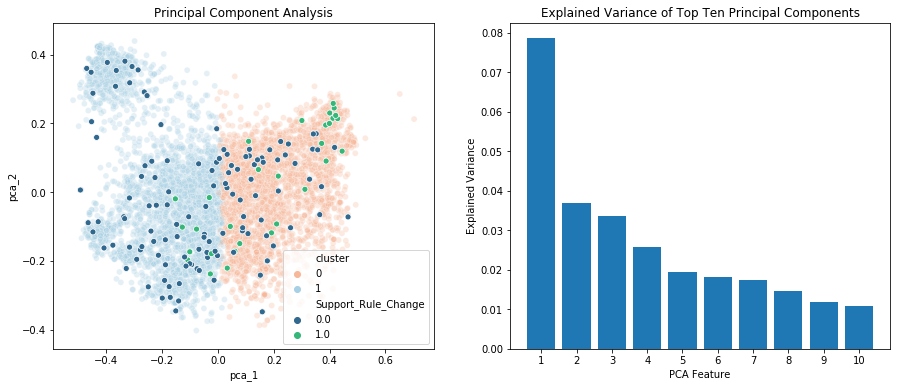

In [80]:
# Plot first two principal components and explained variance
plt.subplots(1, 2, figsize=(15, 6));
plt.subplot(1, 2, 1);
sns.scatterplot(x='pca_1', y='pca_2', data=pca_df, hue='cluster', alpha=0.3, palette='RdBu');
sns.scatterplot(x='pca_1', y='pca_2', data=samples, hue='Support_Rule_Change', palette='viridis');
plt.title('Principal Component Analysis');

feats = range(1, 11)
plt.subplot(1, 2, 2);
plt.bar(feats, pca.explained_variance_ratio_[:10]);
plt.xticks(feats);
plt.xlabel('PCA Feature');
plt.ylabel('Explained Variance');
plt.title('Explained Variance of Top Ten Principal Components');

# plt.savefig('./Figures/PCA_HashingL2_5000.png');

In [56]:
# Create and fit a KMeans algorithm using top 2 PCA features
X_pca = pca_df.loc[:, ['pca_1', 'pca_2']]

# Crude line separating clusters: y = 3/6 * x + 0.35
X_pca['small_cl'] = (X_pca['pca_2'] > X_pca['pca_1'] * 3/6 + 0.35).astype(int)

X_pca.head()

,pca_1,pca_2,small_cl
3783,0.394497,0.200157,0
2110,0.086650,-0.199716,0
2002,-0.232677,-0.210340,0
3047,-0.370968,0.312779,1
418,-0.124500,-0.092041,0


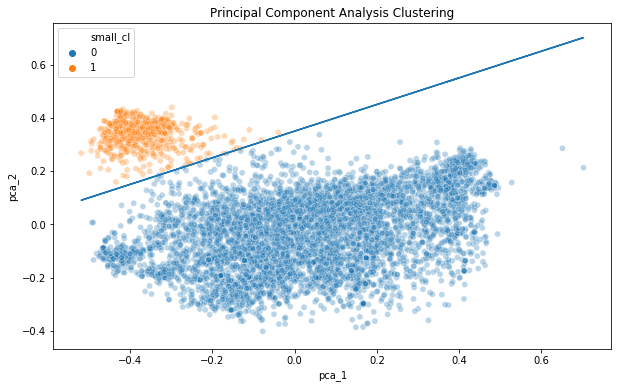

In [57]:
# Plot principal components and clusters
# Approximate line between two clusters
plt.figure(figsize=(10, 6));
sns.scatterplot(x='pca_1', y='pca_2', data=X_pca, hue='small_cl', alpha=0.3);
plt.plot(X_pca['pca_1'], X_pca['pca_1']*3/6 + 0.35);
plt.title('Principal Component Analysis Clustering');

In [63]:
import random
random.seed(42)

In [76]:
# Print comments from small cluster
small_cluster = X_train[X_pca['small_cl'] == 1]

for _ in range(20):
    idx = random.choice(small_cluster.index)
    print('Comment index: {}'.format(idx))
    print(X_train.loc[idx])
    print('\n----------\n')

Comment index: 3871
The South is home to iconic American landscapes, culturally rich communities, and a flourishing outdoor industry. All of that depends on our waterways, which provide drinking water to millions of Southerners and power the regions robust economy.Not to mention all the millions of living things that depend on clean water to drink and to use for growth and hydration.  What are you thinking by taking away these protection? Are you trying to poison us all and kill innocents ? I mean what is your purpose?The EPAs proposal to gut the Clean Water Act by removing protections for our streams and smaller waterways endangers our families. Whats dumped in these tributaries will inevitably be carried to larger bodies of water throughout the region. Despite what polluting industries may say, history has shown that they cant be trusted to regulate themselves. The Clean Water Act is the bedrock environmental policy that protects Americans with basic limits on industrial pollution of

In [83]:
# TSNE cluster visualization
tsne = TSNE(n_components=2, perplexity=30)
tsne_res = tsne.fit_transform(X_data)

In [84]:
tsne_res.shape

(6549, 2)

In [85]:
# Re-create DF with TSNE results
tsne_df = pd.DataFrame(tsne_res, columns=['tsne_1', 'tsne_2'], index=X_train.index)
tsne_df['cluster'] = kmeans.labels_

tsne_df.head()

,tsne_1,tsne_2,cluster
3783,5.334044,-25.372610,0
2110,10.867088,-44.915253,0
2002,16.132757,5.168107,1
3047,-35.657169,20.081091,1
418,-20.013361,-6.323957,1


In [86]:
# Create TSNE sample DF
tsne_samples = pd.merge(labels, tsne_df[['tsne_1', 'tsne_2']],
                        left_index=True,
                        right_index=True)

tsne_samples.tail(10)

,Support_Rule_Change,tsne_1,tsne_2
193,0.0,-14.728728,5.786315
194,0.0,-2.796026,23.949749
195,1.0,12.806684,-30.646662
196,0.0,-59.013191,-4.917164
197,1.0,-11.104682,-31.876089
200,0.0,-18.020960,29.571747
201,0.0,30.929407,14.646724
202,0.0,-34.159306,-9.700859
203,0.0,-28.297800,-2.474410
204,0.0,-19.947735,-5.220685


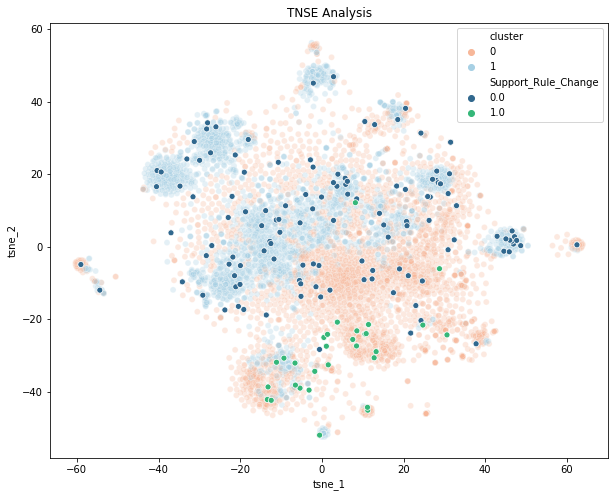

In [88]:
# Plot the TSNE results
plt.figure(figsize=(10, 8));
sns.scatterplot(x='tsne_1', y='tsne_2', data=tsne_df, hue='cluster', alpha=0.3, palette='RdBu');
sns.scatterplot(x='tsne_1', y='tsne_2', data=tsne_samples, hue='Support_Rule_Change', palette='viridis');
plt.title('TNSE Analysis');